<a href="https://colab.research.google.com/github/madeleinegates/Transportation-Modeling-RNN/blob/main/ANN_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data files found in drive; first mount Google Drive

In [1]:
from tensorflow.python.client import device_lib
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Ran the following during first pass:

In [ ]:
# !pip install --upgrade tensorflow-gpu

In [37]:
import pandas as pd 
from pandas import read_csv

import keras
import matplotlib.pyplot as plt
import os

import numpy as np
from numpy import argmax

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.losses import BinaryCrossentropy

from matplotlib import pyplot as plt

Upload data files for use

In [3]:
train = pd.read_csv('/content/drive/My Drive/train_final.csv')
train.head()

,trip_id,household_id,person_n,trip_n,id,travel_mode,y,year,month,day,...,child_fare,free_fare,over_16_fare,no_car,under_one_car,at_least_one_car,snow,no_rain,light_rain,rain
0,0,0,0,0,1,drive,3,2012,4,1,...,0,0,0,0,0,1,0,1,0,0
1,1,0,0,1,1,drive,3,2012,4,1,...,0,0,0,0,0,1,0,1,0,0
2,2,0,0,2,1,drive,3,2012,4,1,...,0,0,0,0,0,1,0,1,0,0
3,3,0,0,3,1,drive,3,2012,4,1,...,0,0,0,0,0,1,0,1,0,0
4,4,0,1,2,2,drive,3,2012,4,1,...,0,0,0,0,0,1,0,1,0,0


In [4]:
dev = pd.read_csv('/content/drive/My Drive/dev_final.csv')
dev.head()

,trip_id,household_id,person_n,trip_n,id,travel_mode,y,year,month,day,...,child_fare,free_fare,over_16_fare,no_car,under_one_car,at_least_one_car,snow,no_rain,light_rain,rain
0,167,35,0,1,1,walk,0,2012,4,2,...,0,1,0,1,0,0,0,1,0,0
1,254,55,0,0,2,pt,2,2012,4,3,...,0,0,0,1,0,0,0,1,0,0
2,255,55,0,1,2,pt,2,2012,4,3,...,0,0,0,1,0,0,0,1,0,0
3,256,55,1,0,3,pt,2,2012,4,3,...,1,0,0,1,0,0,0,1,0,0
4,257,55,1,1,3,pt,2,2012,4,3,...,1,0,0,1,0,0,0,1,0,0


In [9]:
test = pd.read_csv('/content/drive/My Drive/test_final.csv')
test.head()

,trip_id,household_id,person_n,trip_n,id,travel_mode,y,year,month,day,...,child_fare,free_fare,over_16_fare,no_car,under_one_car,at_least_one_car,snow,no_rain,light_rain,rain
0,135,28,0,0,1,drive,3,2012,4,2,...,0,1,0,0,0,1,0,1,0,0
1,136,28,0,1,1,drive,3,2012,4,2,...,0,1,0,0,0,1,0,1,0,0
2,137,28,0,2,1,drive,3,2012,4,2,...,0,1,0,0,0,1,0,1,0,0
3,138,28,0,3,1,drive,3,2012,4,2,...,0,1,0,0,0,1,0,1,0,0
4,171,37,0,0,2,pt,2,2012,4,2,...,0,0,1,0,0,1,0,1,0,0


Separate output column (transportation mode) and preprocess to correct format

In [6]:
y_train = train['y'].tolist()
y_train = np.array(y_train)
y_train.shape

(70913,)

In [7]:
y_dev = dev['y'].tolist()
y_dev = np.array(y_dev)
y_dev.shape

(5104,)

In [10]:
y_test = test['y'].tolist()
y_test = np.array(y_test)
y_test.shape

(5069,)

Separate input code, ensure formatted correctly

In [11]:
x_train = train.iloc[:, 10:]
x_train.astype('float32')

,day_of_week,start_time_linear,bus_scale,age,female,driving_license,distance,dur_walking,dur_cycling,dur_pt_total,...,child_fare,free_fare,over_16_fare,no_car,under_one_car,at_least_one_car,snow,no_rain,light_rain,rain
0,7.0,10.000000,1.0,0.856319,1.0,1.0,-0.802591,-0.816899,-0.768852,-1.027322,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,7.0,13.000000,1.0,0.856319,1.0,1.0,-0.802591,-0.842894,-0.854537,-0.967361,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,7.0,17.000000,1.0,0.856319,1.0,1.0,-0.014189,-0.086297,-0.022845,-0.180699,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,7.0,17.350000,1.0,0.856319,1.0,1.0,-0.014189,-0.084812,0.058124,-0.015133,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,7.0,19.583334,1.0,0.752508,0.0,1.0,-0.014189,-0.086297,-0.022845,-0.247820,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70908,2.0,12.000000,1.0,-0.545135,0.0,1.0,2.305807,2.319413,1.962840,1.763134,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
70909,2.0,14.750000,1.0,-0.545135,0.0,1.0,2.053284,2.039651,1.668053,1.004216,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
70910,2.0,16.000000,1.0,-0.545135,0.0,1.0,-0.625076,-0.580462,-0.494504,-0.590586,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
70911,2.0,7.250000,1.0,-0.752757,1.0,1.0,1.735965,1.834657,2.024942,1.504494,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [12]:
x_dev = dev.iloc[:, 10:]
x_dev.astype('float32')

,day_of_week,start_time_linear,bus_scale,age,female,driving_license,distance,dur_walking,dur_cycling,dur_pt_total,...,child_fare,free_fare,over_16_fare,no_car,under_one_car,at_least_one_car,snow,no_rain,light_rain,rain
0,1.0,13.25,0.0,1.582999,0.0,0.0,-0.876139,-0.879783,-0.745269,-1.037167,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2.0,12.00,0.0,-0.233700,1.0,0.0,1.144455,1.107274,1.253779,1.532237,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2.0,19.00,0.0,-0.233700,1.0,0.0,1.144455,1.112968,1.355972,1.477645,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2.0,12.00,0.0,-1.323720,0.0,0.0,1.144455,1.107274,1.253779,1.532237,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2.0,19.00,0.0,-1.323720,0.0,0.0,1.144455,1.112968,1.355972,1.477645,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5099,6.0,16.50,0.0,1.582999,1.0,1.0,-0.730918,-0.736436,-0.677665,-0.522570,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5100,6.0,20.00,0.0,1.582999,1.0,1.0,-0.730918,-0.731980,-0.665873,-0.636229,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5101,5.0,8.50,1.0,-0.700852,1.0,1.0,-0.093154,-0.010539,-0.007909,0.128059,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5102,5.0,23.00,1.0,-0.700852,1.0,1.0,-0.878431,-0.923357,-0.773569,-1.229581,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
x_test = test.iloc[:, 10:]
x_test.astype('float32')

,day_of_week,start_time_linear,bus_scale,age,female,driving_license,distance,dur_walking,dur_cycling,dur_pt_total,...,child_fare,free_fare,over_16_fare,no_car,under_one_car,at_least_one_car,snow,no_rain,light_rain,rain
0,1.0,10.000000,0.0,2.309678,0.0,1.0,-0.791757,-0.738169,-0.786932,-0.480507,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,11.166667,0.0,2.309678,0.0,1.0,-0.791757,-0.735941,-0.819162,-0.562843,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.0,18.000000,0.0,2.309678,0.0,1.0,0.454394,0.551462,0.832431,0.395650,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.0,21.083334,0.0,2.309678,0.0,1.0,0.454394,0.484121,0.491264,0.490514,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,7.500000,0.0,-1.219908,1.0,0.0,-0.203372,-0.231625,-0.165128,0.111950,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5064,2.0,17.000000,0.0,-1.323720,0.0,0.0,-0.027315,-0.056093,-0.182423,-0.048246,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5065,3.0,8.666667,1.0,-0.181795,1.0,1.0,0.337092,0.354391,0.631975,-0.028557,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5066,3.0,18.166666,1.0,-0.181795,1.0,1.0,0.337092,0.323691,0.540002,0.000976,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5067,3.0,21.000000,1.0,-0.960380,1.0,1.0,-0.016689,-0.080851,-0.086519,-0.447394,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [14]:
print(x_train.shape, x_dev.shape, x_test.shape)

(70913, 45) (5104, 45) (5069, 45)


Build model

In [31]:
ann = Sequential()
ann.add(Dense(13, activation='relu', kernel_initializer='he_normal', input_shape=(45,)))
ann.add(Dense(4, activation = 'softmax'))

In [32]:
ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(ann.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 13)                598       
                                                                 
 dense_5 (Dense)             (None, 4)                 56        
                                                                 
Total params: 654
Trainable params: 654
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
fittingann = ann.fit(x_train, y_train, epochs=200, batch_size=32, verbose=1, validation_data = (x_dev, y_dev))

Epoch 1/200
2217/2217 [==============================] - 4s 2ms/step - loss: 0.8628 - accuracy: 0.6832 - val_loss: 0.7178 - val_accuracy: 0.7267
Epoch 2/200
2217/2217 [==============================] - 4s 2ms/step - loss: 0.6925 - accuracy: 0.7309 - val_loss: 0.7136 - val_accuracy: 0.7200
Epoch 3/200
2217/2217 [==============================] - 4s 2ms/step - loss: 0.6827 - accuracy: 0.7340 - val_loss: 0.7021 - val_accuracy: 0.7318
Epoch 4/200
2217/2217 [==============================] - 4s 2ms/step - loss: 0.6760 - accuracy: 0.7371 - val_loss: 0.7010 - val_accuracy: 0.7226
Epoch 5/200
2217/2217 [==============================] - 4s 2ms/step - loss: 0.6704 - accuracy: 0.7394 - val_loss: 0.6978 - val_accuracy: 0.7302
Epoch 6/200
2217/2217 [==============================] - 4s 2ms/step - loss: 0.6659 - accuracy: 0.7413 - val_loss: 0.6854 - val_accuracy: 0.7353
Epoch 7/200
2217/2217 [==============================] - 4s 2ms/step - loss: 0.6622 - accuracy: 0.7425 - val_loss: 0.6895 - val_ac

Historical loss graph creation:
Reference for model graph creation code:
https://chrisalbon.com/code/deep_learning/keras/visualize_loss_history/

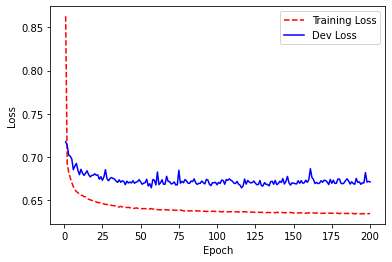

In [39]:
# Get training and test loss histories
training_loss = fittingann.history['loss']
dev_loss = fittingann.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Create plot
plt.plot(epochs, training_loss, 'r--')
plt.plot(epochs, dev_loss, 'b-')
plt.legend(['Training Loss', 'Dev Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('ann_loss.png', bbox_inches='tight')

Historical Accuracy graph creation:

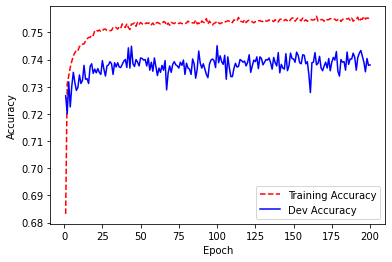

In [40]:
# Get training and dev accuracy histories:
training_acc = fittingann.history['accuracy']
dev_acc = fittingann.history['val_accuracy']
epochs = range(1, len(training_acc) + 1)

# Visualize loss history
plt.plot(epochs, training_acc, 'r--')
plt.plot(epochs, dev_acc, 'b-')
plt.legend(['Training Accuracy', 'Dev Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('ann_accuracy.png', bbox_inches='tight')

In [41]:
ann.fit(x_train, y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
2217/2217 [==============================] - 4s 2ms/step - loss: 0.6346 - accuracy: 0.7552
Epoch 2/100
2217/2217 [==============================] - 4s 2ms/step - loss: 0.6339 - accuracy: 0.7550
Epoch 3/100
2217/2217 [==============================] - 4s 2ms/step - loss: 0.6345 - accuracy: 0.7554
Epoch 4/100
2217/2217 [==============================] - 4s 2ms/step - loss: 0.6342 - accuracy: 0.7553
Epoch 5/100
2217/2217 [==============================] - 4s 2ms/step - loss: 0.6340 - accuracy: 0.7555
Epoch 6/100
2217/2217 [==============================] - 4s 2ms/step - loss: 0.6342 - accuracy: 0.7540
Epoch 7/100
2217/2217 [==============================] - 3s 2ms/step - loss: 0.6341 - accuracy: 0.7553
Epoch 8/100
2217/2217 [==============================] - 3s 2ms/step - loss: 0.6346 - accuracy: 0.7553
Epoch 9/100
2217/2217 [==============================] - 4s 2ms/step - loss: 0.6341 - accuracy: 0.7548
Epoch 10/100
2217/2217 [==============================] - 4s 2ms/step - l

In [42]:
loss, accuracy = ann.evaluate(x_dev, y_dev, verbose=0)
print(loss, accuracy)

0.6712870001792908 0.7421630024909973


In [43]:
loss, accuracy = ann.evaluate(x_test, y_test, verbose=0)
print(loss, accuracy)

0.6384233236312866 0.7524166703224182
